### Load necessary packages

In [193]:
# Manual SARIMA modeling and backtesting for CAISO RA weighted avg price'

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error

### 1. Run baseline pipeline
Our first pipeline will be a baseline SARIMAX time series model. The second pipeline will consider exogenous features within the dataset, with the goal of improving the baseline model.

#### Write helper functions
Includes the following functions:
* Utility function to load data and organize dates
* Metric helper for clean MAE and RMSE values
* Forecasting function for SARIMAX
* AIC-based grid search for best SARIMAX model parameters
* Rolling backtest function to measure model prediction accuracy against real data
* Model comparison function between SARIMAX and Holt-Winters as a benchmark (MAE, RMSE)
* Backtest plot

In [195]:
# Utility function
def load_series(csv_path,
                date_col="trade_date_year_mo",
                value_col="weighted_avg_price"):
    df = pd.read_csv(csv_path)

     # convert YYYY-MM to PeriodIndex (true monthly data)
    df[date_col] = pd.PeriodIndex(df[date_col], freq="M")
    df = df.sort_values(date_col).reset_index(drop=True)

    ts = df.set_index(date_col)[value_col].astype(float)

    # enforce regular monthly frequency
    ts = ts.asfreq("M")

    # interpolate missing months if necessary
    if ts.isna().sum() > 0:
        print("Missing months detected -> interpolating")
        ts = ts.interpolate(method='linear')

    return ts

# Metric helper
def metrics_df(y_true, y_pred):
    # MAE and RMSE with NaN protection.
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        return {"MAE": np.nan, "RMSE": np.nan}

    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    }

# Model forecast functions
def sarimax_forecast(train, h, order, seasonal_order):
    model = SARIMAX(
        train.to_timestamp(),
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    fc = model.get_forecast(steps=h)
    values = fc.predicted_mean.values

    last_period = train.index[-1]
    idx = pd.period_range(start=last_period + 1, periods=h, freq="M")
    return pd.Series(values, index=idx)

def holtwinters_forecast(train, h, seasonal_periods=12, trend="add", seasonal="add"):
    model = ExponentialSmoothing(
        train.to_timestamp(),
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods
    ).fit(optimized=True)

    fc = model.forecast(h)
    last_period = train.index[-1]
    idx = pd.period_range(start=last_period + 1, periods=h, freq="M")
    return pd.Series(fc.values, index=idx)

# SARIMAX grid search
def sarimax_grid_search_small(ts, s=12):
    # Small SARIMAX grid search over (p,d,q,P,D,Q) using AIC. Returns (order, seasonal_order).
    best_aic = np.inf
    best_cfg = None

    # Small ranges to keep it fast
    p_values = [0, 1, 2]
    d_values = [0, 1]
    q_values = [0, 1, 2]
    P_values = [0, 1]
    D_values = [0, 1]
    Q_values = [0, 1]

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, s)
                            try:
                                model = SARIMAX(
                                    ts.to_timestamp(),
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                ).fit(disp=False)
                                aic = model.aic
                                if aic < best_aic:
                                    best_aic = aic
                                    best_cfg = (order, seasonal_order)
                            except Exception:
                                continue

    print("Best AIC:", best_aic)
    print("Best order:", best_cfg[0], "Best seasonal:", best_cfg[1])
    return best_cfg

# Rolling backtest
def rolling_backtest_generic(
    ts,
    forecast_func,
    forecast_args={},
    horizon=6,
    initial_train=36,
    step=3
):

    preds_all = []
    truths_all = []

    for i in range(initial_train, len(ts) - horizon + 1, step):

        train = ts.iloc[:i]
        test = ts.iloc[i:i+horizon]

        preds = forecast_func(train, h=horizon, **forecast_args)

        if not isinstance(preds.index, pd.PeriodIndex):
            preds.index = preds.index.to_period("M")
        if not isinstance(test.index, pd.PeriodIndex):
            test.index = test.index.to_period("M")

        idx = preds.index.intersection(test.index)
        if len(idx) == 0:
            continue

        preds_all.append(preds.loc[idx])
        truths_all.append(test.loc[idx])

    if len(preds_all) == 0:
        print("WARNING: No valid backtest observations collected.")
        return pd.Series(dtype=float), pd.Series(dtype=float)

    preds_all = pd.concat(preds_all)
    truths_all = pd.concat(truths_all)

    return preds_all, truths_all

# Model comparison
def compare_models(ts, order, seasonal_order,
                   horizon=6, initial_train=36, step=3):

    results = {}

    # SARIMAX
    preds_sarima, truths = rolling_backtest_generic(
        ts,
        sarimax_forecast,
        forecast_args={"order": order, "seasonal_order": seasonal_order},
        horizon=horizon,
        initial_train=initial_train,
        step=step
    )
    results["SARIMAX"] = (
        metrics_df(truths.values, preds_sarima.values),
        preds_sarima,
        truths
    )

    # Holt‑Winters
    preds_hw, truths_hw = rolling_backtest_generic(
        ts,
        holtwinters_forecast,
        forecast_args={"seasonal_periods": 12, "trend": "add", "seasonal": "add"},
        horizon=horizon,
        initial_train=initial_train,
        step=step
    )
    results["Holt-Winters"] = (
        metrics_df(truths_hw.values, preds_hw.values),
        preds_hw,
        truths_hw
    )

    return results

# Plot backtest
def plot_backtest(truths, preds, title):

    plt.figure(figsize=(12,6))
    plt.plot(truths.index.to_timestamp(), truths, label="Actual")
    plt.plot(preds.index.to_timestamp(), preds, label="Predicted")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Weighted Avg Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Main function for fitting baseline model
What the function does:
* Loads data with trade year+month and weighted average price
* Chooses SARIMAX parameters using AIC grid search
* Defines backtest configuration compares SARIMAX vs. Holt-Winters based on MAE and RMSE
* Fits final SARIMAX on all data
* Forecasts and plots the next 12 months

In [202]:
# Main function
def main_baseline():

    ts = load_series("weighted_avg_price_monthly.csv")
    print(ts.head())
    print("Total months:", len(ts))

    # Choose (p,d,q)(P,D,Q,12) by small AIC grid search
    order, seasonal_order = sarimax_grid_search_small(ts, s=12)
    horizon = 6
    initial_train = 36
    step = 3

    # Compare SARIMAX vs Holt‑Winters
    comp = compare_models(
        ts,
        order=order,
        seasonal_order=seasonal_order,
        horizon=horizon,
        initial_train=initial_train,
        step=step
    )

    rows = []
    for model_name, (metrics, preds, truths) in comp.items():
        rows.append({"Model": model_name, **metrics})
        plot_backtest(truths, preds, title=f"{model_name} Rolling Backtest")

    df_metrics = pd.DataFrame(rows)
    print("\nMODEL COMPARISON:")
    print(df_metrics)

    # Fit final SARIMAX on full data
    print("\nFitting final SARIMAX model on full data...")
    final_model = SARIMAX(
        ts.to_timestamp(),
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    print(final_model.summary())

    # Plot actual vs. fitted for SARIMAX
    plt.figure(figsize=(12, 5))
    plt.plot(ts.index.to_timestamp(), ts, label="Actual")
    plt.plot(ts.index.to_timestamp(),
            final_model.fittedvalues, label="Fitted")
    plt.title("SARIMAX Fit on Full Data")
    plt.xlabel("Date")
    plt.ylabel("Weighted Avg Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 12‑month forecast
    steps = 12
    fc = final_model.get_forecast(steps=steps)
    forecast_values = fc.predicted_mean.values
    conf_values = fc.conf_int(alpha=0.05).values

    last_period = ts.index[-1]
    forecast_index = pd.period_range(start=last_period + 1, periods=steps, freq="M")

    forecast = pd.Series(forecast_values, index=forecast_index)
    conf = pd.DataFrame(conf_values, index=forecast_index, columns=["Lower", "Upper"])

    plt.figure(figsize=(14,6))
    plt.plot(ts.index.to_timestamp(), ts, label="Historical")
    plt.plot(forecast.index.to_timestamp(), forecast, label="Forecast")
    plt.fill_between(
        forecast.index.to_timestamp(),
        conf["Lower"],
        conf["Upper"],
        alpha=0.25,
        label="95% Confidence Interval"
    )
    plt.title("12-Month SARIMAX Forecast of Capacity Prices")
    plt.xlabel("Date")
    plt.ylabel("Weighted Avg Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

    forecast_df = pd.DataFrame({
        "Month": forecast.index.astype(str),
        "Forecast": forecast.values,
        "Lower_95CI": conf["Lower"].values,
        "Upper_95CI": conf["Upper"].values
    })
    forecast_df.to_csv("final_forecast_12mo_baseline.csv", index=False)
    print("\nSaved baseline forecast to final_forecast_12mo_baseline.csv")

    # --- Holt-Winters final fit and actual vs fitted ---
    print("\nFitting final Holt-Winters model on full data...")
    hw_model = ExponentialSmoothing(
        ts.to_timestamp(),
        trend="add",
        seasonal="add",
        seasonal_periods=12
    ).fit(optimized=True)

    plt.figure(figsize=(12, 5))
    plt.plot(ts.index.to_timestamp(), ts, label="Actual")
    plt.plot(ts.index.to_timestamp(),
             hw_model.fittedvalues, label="Fitted (Holt-Winters)")
    plt.title("Holt-Winters: Actual vs Fitted")
    plt.xlabel("Date")
    plt.ylabel("Weighted Avg Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Results
Shows:
* Best SARIMAX parameters and model fitting results
* Plots for backtesting
* Model evaluation table with MAE and RMSE
* SARIMAX actual vs. fitted plot
* 12-month SARIMAX forecast plot

trade_date_year_mo
2002-04    14.251082
2006-04     6.837477
2007-04     1.850000
2007-08    14.116104
2008-03     8.469073
Freq: M, Name: weighted_avg_price, dtype: float64
Total months: 128
Best AIC: 628.643508467073
Best order: (1, 1, 2) Best seasonal: (1, 1, 1, 12)


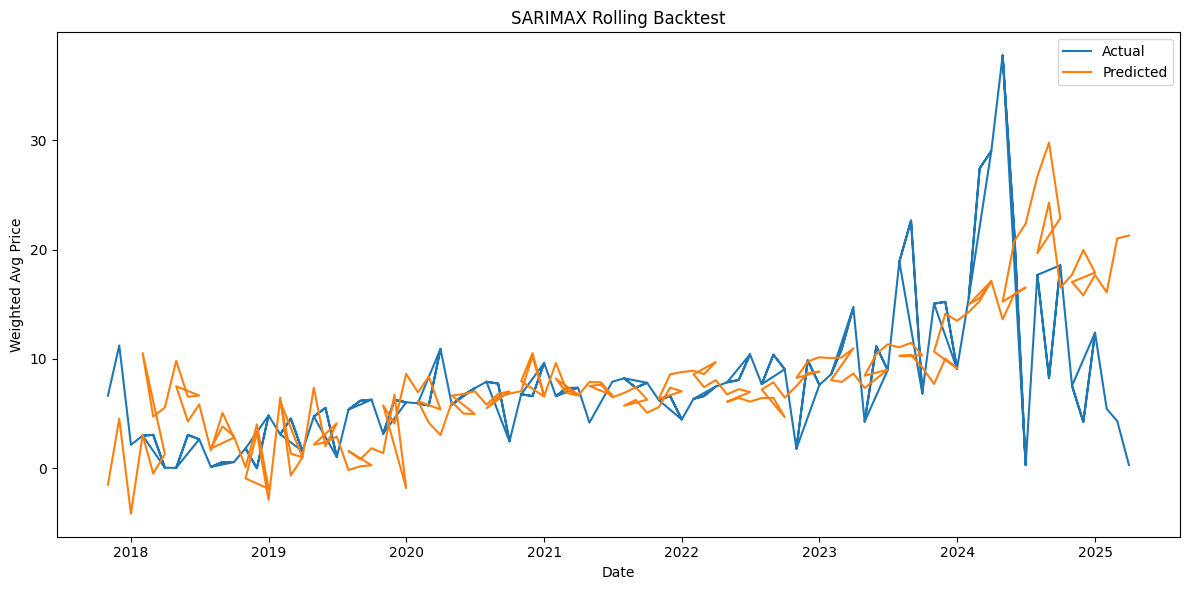

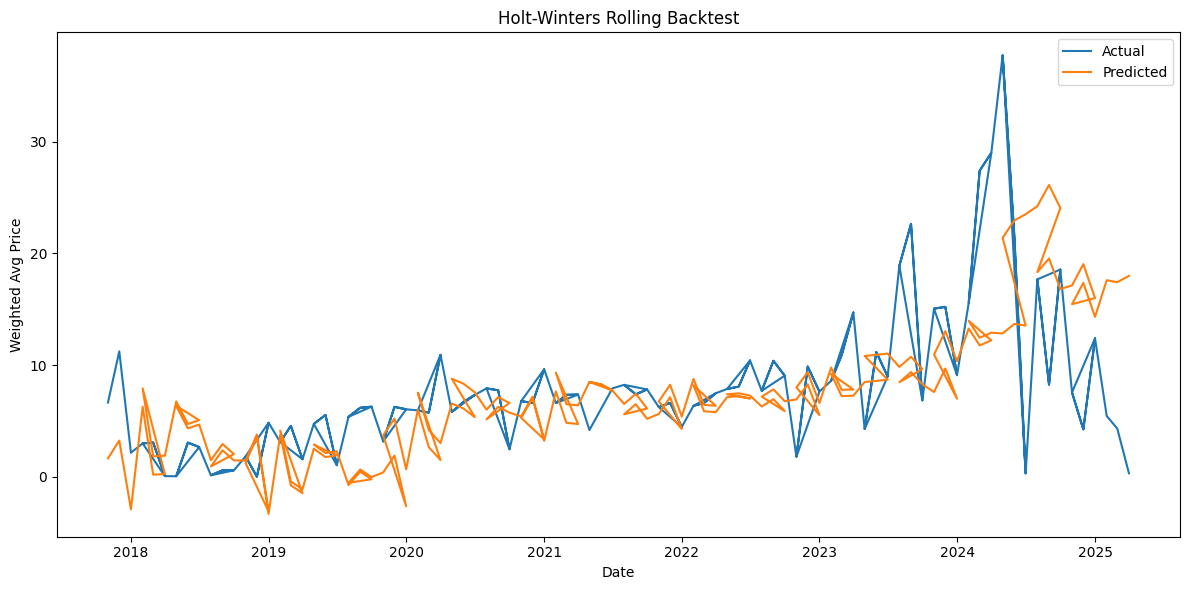


MODEL COMPARISON:
          Model       MAE      RMSE
0       SARIMAX  4.265866  6.290474
1  Holt-Winters  4.172904  6.195879

Fitting final SARIMAX model on full data...
                                      SARIMAX Results                                       
Dep. Variable:                   weighted_avg_price   No. Observations:                  128
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -308.322
Date:                              Mon, 01 Dec 2025   AIC                            628.644
Time:                                      16:53:09   BIC                            644.275
Sample:                                           0   HQIC                           634.970
                                              - 128                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

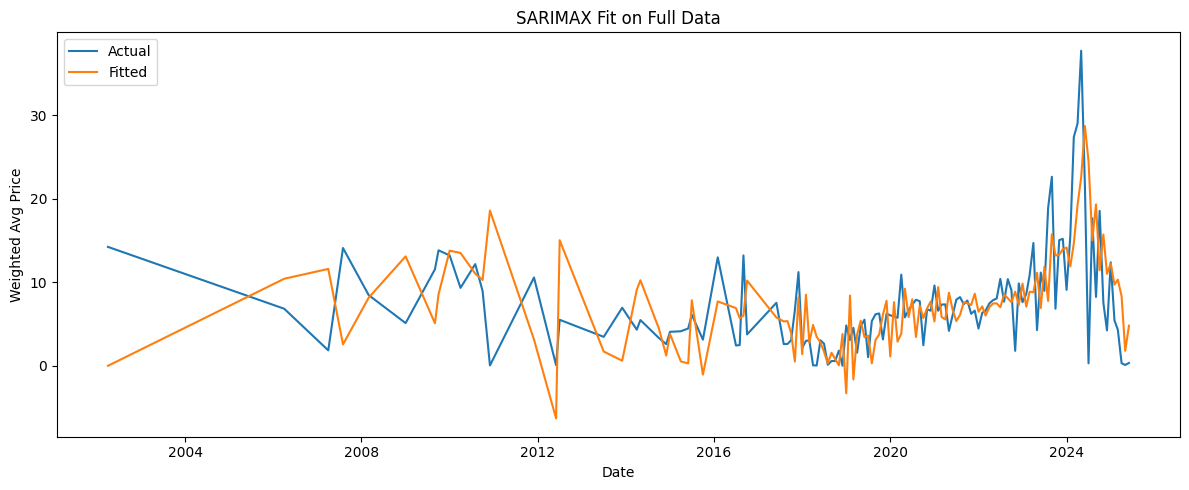

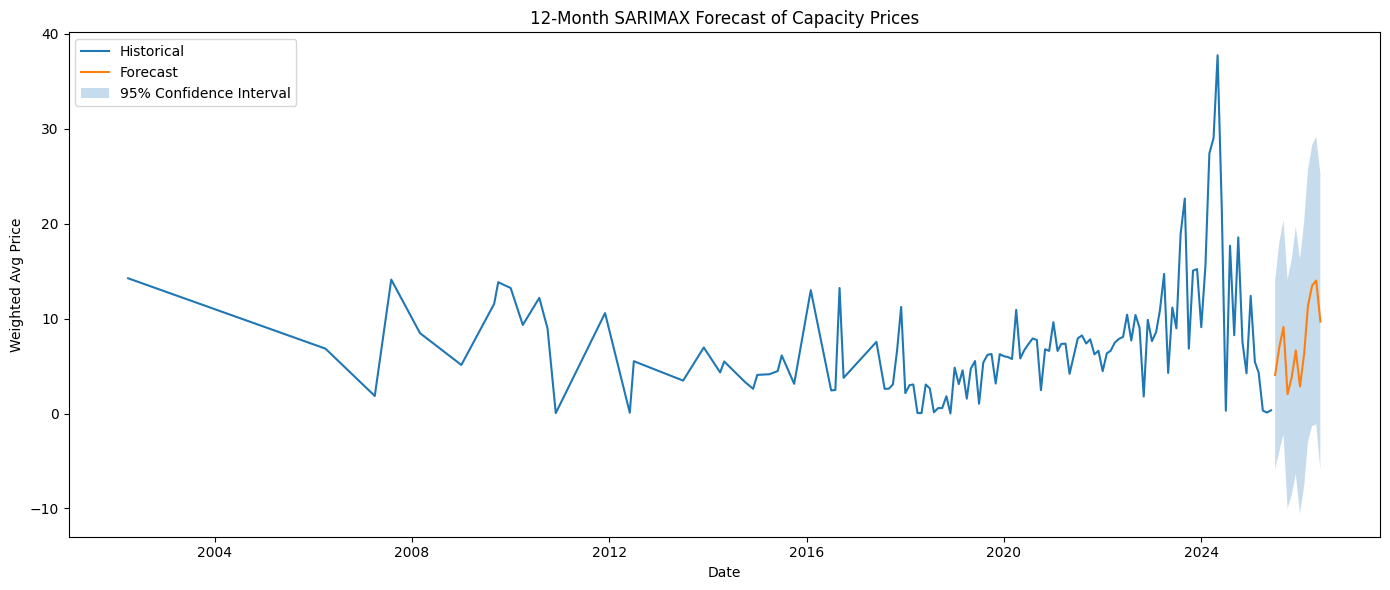


Saved baseline forecast to final_forecast_12mo_baseline.csv

Fitting final Holt-Winters model on full data...


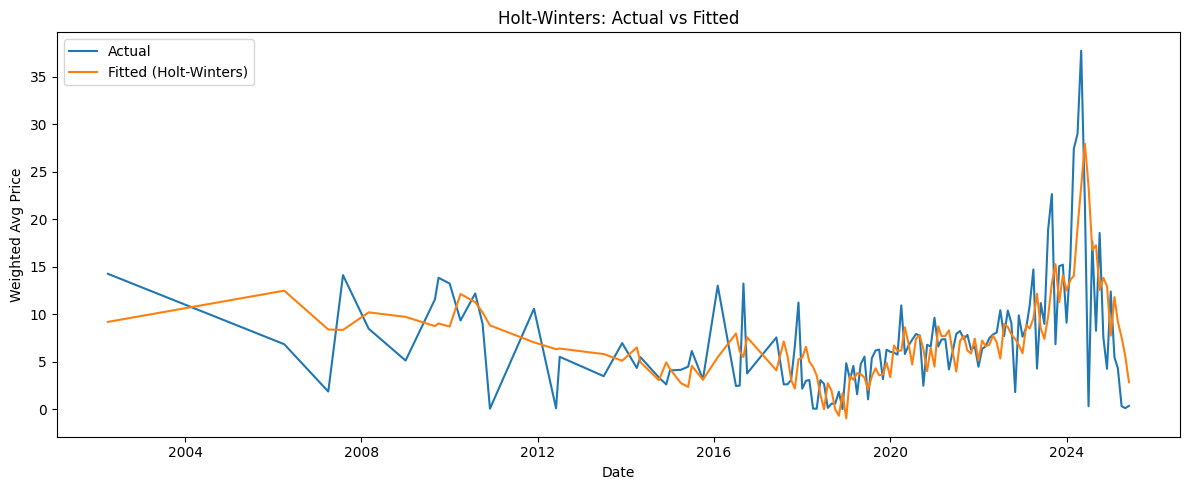

In [203]:
main_baseline()

### 2. Run second pipeline, considering exogenous features
From our dataset, we consider the following features that may affect price:
* total_std_qty (sum of standardized_quantity per month)
    - Answers: How much capacity is traded?
* total_charge (sum of total_transaction_charge per month)
    - Answers: How many dollars flow?
* mean_price (average converted_price per trade that month)
    - Answers: What are typical deal prices?
* n_trades (number of unique transaction_unique_id per month)
    - Answers: How active is the market?
* lt_share (share of trades that are long-term, term_name == "LT")
    - Answers: What is the contract mix and expectation?

We create the following functions:
* Build monthly exogenous (exog) features
* AIC-based SARIMAX grid search, including exog
* SARIMAX forecast with exog
* Rolling backtest with exog
* Model comparison for SARIMAX (with exog) vs. Holt-Winters (no exog)
* Forecast for single exogenous series with SARIMAX (tests forecasting with exogenous features)

In [199]:
# Build monthly exogenous features
def build_exog_monthly(csv_path_tx="EQR_master_clean_new.csv"):
    df_tx = pd.read_csv(csv_path_tx)

    # Monthly PeriodIndex
    df_tx["trade_date_year_mo"] = pd.PeriodIndex(
        df_tx["trade_date_year_mo"], freq="M"
    )

    # Numeric aggregates
    exog_monthly = (
        df_tx.groupby("trade_date_year_mo")
             .agg(
                 total_std_qty=("standardized_quantity", "sum"),
                 total_charge=("total_transaction_charge", "sum"),
                 mean_price=("converted_price", "mean"),
                 n_trades=("transaction_unique_id", "nunique"),
             )
    )

    # Long‑term share
    df_tx["is_LT"] = (df_tx["term_name"] == "LT").astype(int)
    lt_share = (
        df_tx.groupby("trade_date_year_mo")["is_LT"]
             .mean()
             .rename("lt_share")
    )
    exog_monthly = exog_monthly.join(lt_share, how="left")

    return exog_monthly

# Small SARIMAX grid search using AIC (including exogenous variables)
def sarimax_grid_search_small(ts, exog=None, s=12):
    """
    Very small SARIMAX grid search over (p,d,q,P,D,Q) with AIC.
    Returns (order, seasonal_order).
    """
    best_aic = np.inf
    best_cfg = ((1, 1, 1), (1, 1, 1, s))

    for p in [0, 1, 2]:
        for d in [0, 1]:
            for q in [0, 1, 2]:
                for P in [0, 1]:
                    for D in [0, 1]:
                        for Q in [0, 1]:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, s)
                            try:
                                model = SARIMAX(
                                    ts.to_timestamp(),
                                    exog=exog.to_timestamp() if exog is not None else None,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                ).fit(disp=False)
                                aic = model.aic
                                if aic < best_aic:
                                    best_aic = aic
                                    best_cfg = (order, seasonal_order)
                            except Exception:
                                continue

    print("Best AIC:", best_aic)
    print("Best order:", best_cfg[0], "Best seasonal:", best_cfg[1])
    return best_cfg

# SARIMAX forecast with exogenous variables
def sarimax_forecast_exog(train, h, order, seasonal_order,
                          exog_train=None, exog_future=None):

    model = SARIMAX(
        train.to_timestamp(),
        exog=exog_train.to_timestamp() if exog_train is not None else None,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    fc = model.get_forecast(
        steps=h,
        exog=exog_future.to_timestamp() if exog_future is not None else None
    )
    values = fc.predicted_mean.values

    last_period = train.index[-1]
    idx = pd.period_range(start=last_period + 1, periods=h, freq="M")
    return pd.Series(values, index=idx)

# Rolling backtest with exogenous variables
def rolling_backtest_generic_exog(
    ts,
    forecast_func,
    forecast_args={},
    horizon=6,
    initial_train=36,
    step=3,
    exog=None
):

    preds_all = []
    truths_all = []

    for i in range(initial_train, len(ts) - horizon + 1, step):

        train = ts.iloc[:i]
        test = ts.iloc[i:i+horizon]

        if exog is not None:
            exog_train = exog.iloc[:i]
            exog_future = exog.iloc[i:i+horizon]
        else:
            exog_train = None
            exog_future = None

        preds = forecast_func(
            train,
            h=horizon,
            exog_train=exog_train,
            exog_future=exog_future,
            **forecast_args
        )

        if not isinstance(preds.index, pd.PeriodIndex):
            preds.index = preds.index.to_period("M")
        if not isinstance(test.index, pd.PeriodIndex):
            test.index = test.index.to_period("M")

        idx = preds.index.intersection(test.index)
        if len(idx) == 0:
            continue

        preds_all.append(preds.loc[idx])
        truths_all.append(test.loc[idx])

    if len(preds_all) == 0:
        print("WARNING: No valid backtest observations collected.")
        return pd.Series(dtype=float), pd.Series(dtype=float)

    preds_all = pd.concat(preds_all)
    truths_all = pd.concat(truths_all)

    return preds_all, truths_all

# Model comparison with exogenous variables
def compare_models_exog(ts, order, seasonal_order,
                        horizon=6, initial_train=36, step=3,
                        exog=None):

    results = {}

    # SARIMAX with exog
    preds_sarima, truths = rolling_backtest_generic_exog(
        ts,
        sarimax_forecast_exog,
        forecast_args={"order": order, "seasonal_order": seasonal_order},
        horizon=horizon,
        initial_train=initial_train,
        step=step,
        exog=exog
    )
    results["SARIMAX_exog"] = (
        metrics_df(truths.values, preds_sarima.values),
        preds_sarima,
        truths
    )

    # Holt‑Winters baseline (no exog) – reuse your no‑exog rolling_backtest_generic
    preds_hw, truths_hw = rolling_backtest_generic(
        ts,
        holtwinters_forecast,
        forecast_args={"seasonal_periods": 12, "trend": "add", "seasonal": "add"},
        horizon=horizon,
        initial_train=initial_train,
        step=step
    )
    results["Holt-Winters"] = (
        metrics_df(truths_hw.values, preds_hw.values),
        preds_hw,
        truths_hw
    )

    return results

# Forecast single exogenous series with SARIMAX
def forecast_exog_series(series, steps=12, order=(1,1,0), seasonal_order=(0,0,0,0)):
    model = SARIMAX(
        series.to_timestamp(),
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    last_period = series.index[-1]
    fc = model.get_forecast(steps=steps)
    idx = pd.period_range(start=last_period + 1, periods=steps, freq="M")
    return pd.Series(fc.predicted_mean.values, index=idx)

#### Main function with exogenous features
We perform the same steps as the baseline main function, using the functions that include exogenous features. However, for the last step of forecasting, we must provde exog for future steps. Since we don't know the future values of these features, we test two different scenarios:
* Assume the future exog remains constant with the most recent observed month.
* Separately model two key exogs (mean_price, total_std_qty) with simple ARIMA to feed into SARIMAX forecast

In [200]:
# Main function with exogenous variables
def main_exog():

    # 1. Load target series
    ts = load_series("weighted_avg_price_monthly.csv")
    print(ts.head())
    print("Total months:", len(ts))

    # 2. Build and align exogenous monthly features
    exog_monthly = build_exog_monthly("EQR_master_clean_new.csv")
    # Align exog to ts index
    exog = exog_monthly.reindex(ts.index).astype(float)

    # 3. Small SARIMAX grid search with exog
    order, seasonal_order = sarimax_grid_search_small(ts, exog=exog, s=12)

    # 4. Backtesting parameters
    horizon = 6
    initial_train = 36
    step = 3

    # 5. Compare SARIMAX_exog vs Holt‑Winters
    comp = compare_models_exog(
        ts,
        order=order,
        seasonal_order=seasonal_order,
        horizon=horizon,
        initial_train=initial_train,
        step=step,
        exog=exog
    )

    rows = []
    for model_name, (metrics, preds, truths) in comp.items():
        rows.append({"Model": model_name, **metrics})
        plot_backtest(truths, preds, title=f"{model_name} Rolling Backtest")

    df_metrics = pd.DataFrame(rows)
    print("\nMODEL COMPARISON (with exog):")
    print(df_metrics)

    # 6. Final SARIMAX_exog on full data
    print("\nFitting final SARIMAX (with exog) on full data...")
    final_model = SARIMAX(
        ts.to_timestamp(),
        exog=exog.to_timestamp(),
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    print(final_model.summary())
    
    # 7. Plot actual vs. fitted for SARIMAX_exog
    plt.figure(figsize=(12, 5))
    plt.plot(ts.index.to_timestamp(), ts, label="Actual")
    plt.plot(ts.index.to_timestamp(),
            final_model.fittedvalues, label="Fitted (with exog)")
    plt.title("SARIMAX with Exogenous Variables: Fit on Full Data")
    plt.xlabel("Date")
    plt.ylabel("Weighted Avg Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 8. Build two exog-future scenarios for 12‑month forecast
    steps = 12

    # 8a) Constant-exog: Repeat last month’s exog row for the forecast horizon
    last_exog = exog.iloc[[-1]].copy()
    exog_future_const = pd.concat([last_exog] * steps)
    exog_future_const.index = pd.period_range(
        start=ts.index[-1] + 1, periods=steps, freq="M"
    )

    # 8b) Modeled-exog: Forecast mean_price and total_std_qty using univariate ARIMA
    mean_price_future = forecast_exog_series(exog["mean_price"], steps=steps,
                                             order=(1,1,0), seasonal_order=(0,0,0,0))
    total_std_qty_future = forecast_exog_series(exog["total_std_qty"], steps=steps,
                                                order=(1,1,0), seasonal_order=(0,0,0,0))

    exog_future_modeled = exog_future_const.copy()
    exog_future_modeled["mean_price"] = mean_price_future.values
    exog_future_modeled["total_std_qty"] = total_std_qty_future.values

    # 9. Forecast under both scenarios
    fc_const = final_model.get_forecast(
        steps=steps,
        exog=exog_future_const.to_timestamp()
    )
    fc_mod = final_model.get_forecast(
        steps=steps,
        exog=exog_future_modeled.to_timestamp()
    )

    forecast_index = exog_future_const.index
    fc_const_series = pd.Series(fc_const.predicted_mean.values, index=forecast_index)
    fc_mod_series = pd.Series(fc_mod.predicted_mean.values, index=forecast_index)

    # 10. Plot both scenarios vs history
    plt.figure(figsize=(14, 6))
    plt.plot(ts.index.to_timestamp(), ts, label="Historical")
    plt.plot(fc_const_series.index.to_timestamp(), fc_const_series,
             label="Forecast (constant exog)")
    plt.plot(fc_mod_series.index.to_timestamp(), fc_mod_series,
             label="Forecast (modeled exog)")
    plt.xlabel("Date")
    plt.ylabel("Weighted Avg Price")
    plt.title("12-Month Forecast: Constant vs Modeled Exogenous Variables")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 11. Save scenario forecasts to CSV
    forecast_df = pd.DataFrame({
        "Month": forecast_index.astype(str),
        "Forecast_const": fc_const_series.values,
        "Forecast_modeled": fc_mod_series.values,
    })
    forecast_df.to_csv("final_forecast_12mo_exog_scenarios.csv", index=False)
    print("\nSaved scenario forecasts to final_forecast_12mo_exog_scenarios.csv")

trade_date_year_mo
2002-04    14.251082
2006-04     6.837477
2007-04     1.850000
2007-08    14.116104
2008-03     8.469073
Freq: M, Name: weighted_avg_price, dtype: float64
Total months: 128
Best AIC: 558.8951331029452
Best order: (0, 0, 0) Best seasonal: (1, 1, 1, 12)


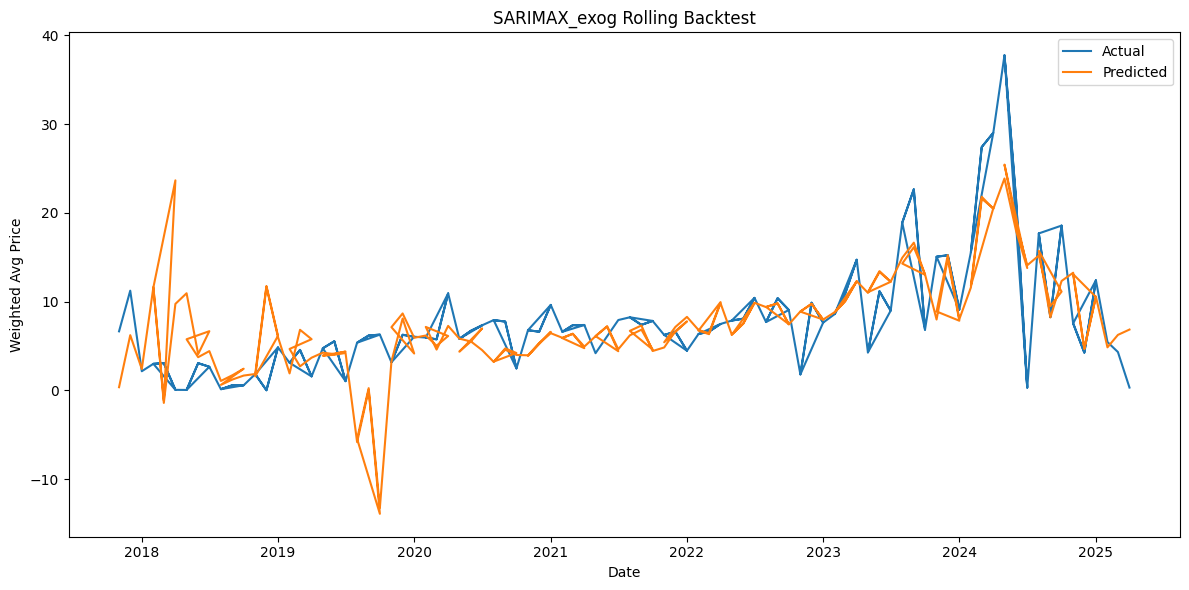

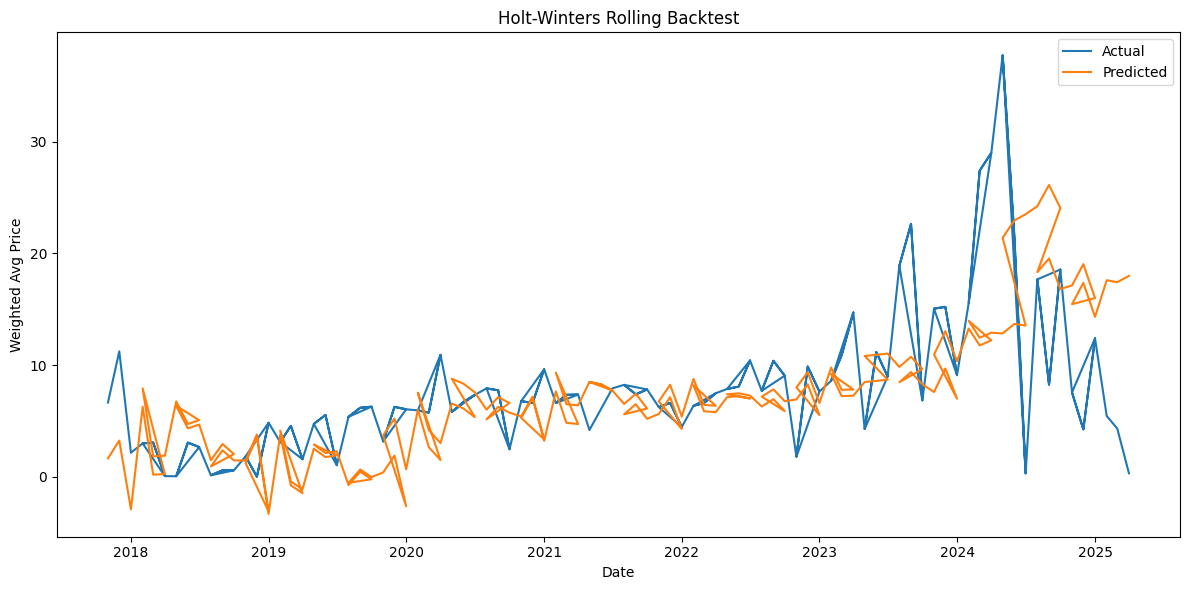


MODEL COMPARISON (with exog):
          Model       MAE      RMSE
0  SARIMAX_exog  3.362030  5.124483
1  Holt-Winters  4.172904  6.195879

Fitting final SARIMAX (with exog) on full data...
                                 SARIMAX Results                                  
Dep. Variable:         weighted_avg_price   No. Observations:                  128
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                -271.448
Date:                    Mon, 01 Dec 2025   AIC                            558.895
Time:                            16:48:12   BIC                            579.973
Sample:                                 0   HQIC                           567.432
                                    - 128                                         
Covariance Type:                      opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

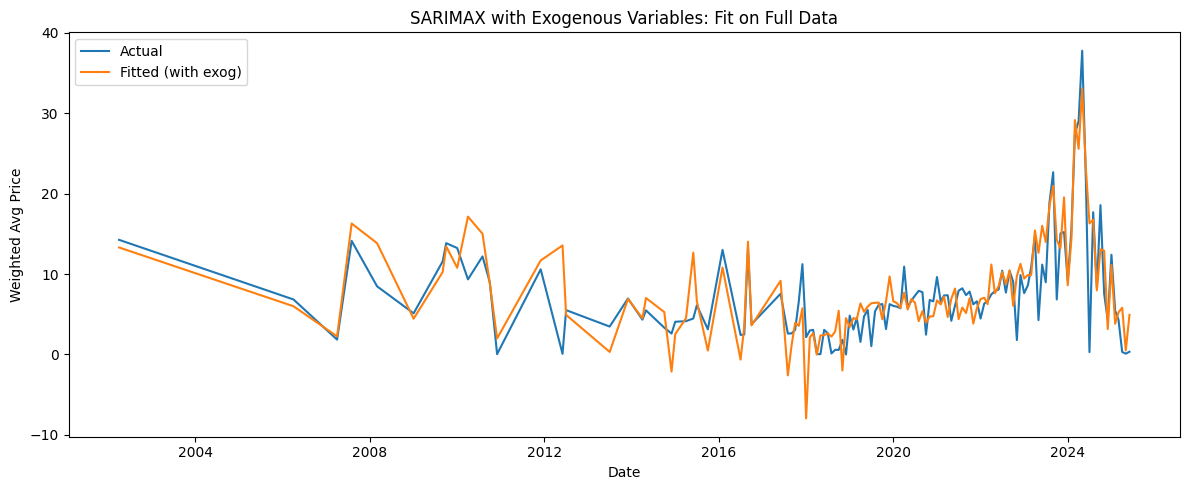

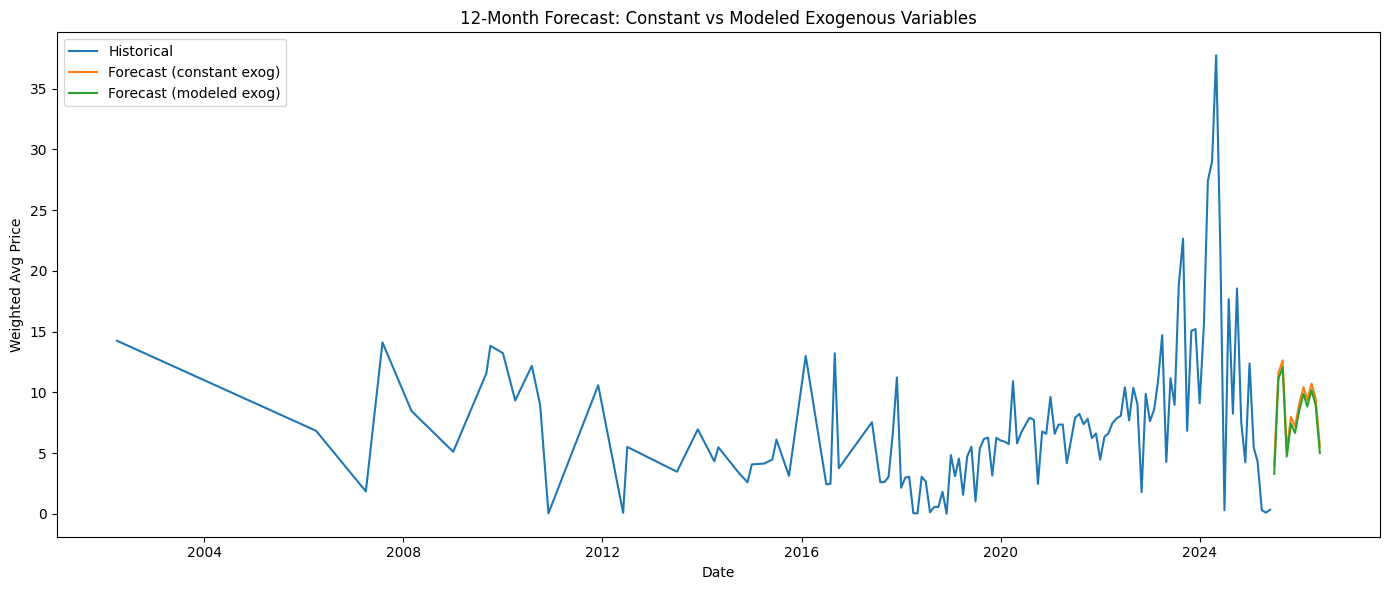


Saved scenario forecasts to final_forecast_12mo_exog_scenarios.csv


In [201]:
main_exog()

#### Checking trend of exogs to test validity of our assumption


=== Last 12 months ===

Std dev:
total_std_qty    3.878087e+04
total_charge     3.933401e+07
mean_price       5.558095e+00
n_trades         4.226566e+01
lt_share         2.588207e-01
dtype: float64

Trend (slope per month):
total_std_qty   -2.368242e+03
total_charge    -4.525869e+06
mean_price      -8.843444e-01
n_trades        -7.884615e+00
lt_share        -3.482735e-02
dtype: float64

=== Last 18 months ===

Std dev:
total_std_qty    3.238335e+04
total_charge     5.631790e+07
mean_price       9.919534e+00
n_trades         3.993410e+01
lt_share         2.550831e-01
dtype: float64

Trend (slope per month):
total_std_qty    3.434774e+02
total_charge    -6.760358e+06
mean_price      -1.194749e+00
n_trades        -4.951496e+00
lt_share        -4.514298e-03
dtype: float64


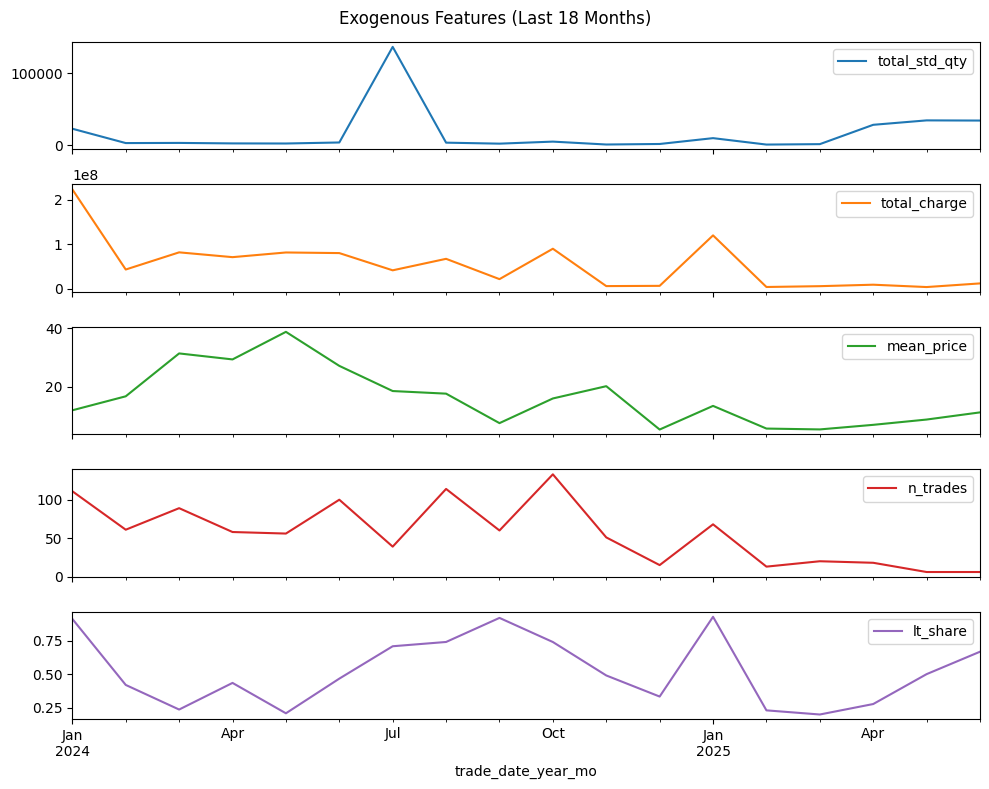

In [188]:
# Choose window sizes (in months)
for window in [12, 18]:
    recent = exog.iloc[-window:]
    print(f"\n=== Last {window} months ===")
    
    # Volatility
    print("\nStd dev:")
    print(recent.std())
    
    # Linear trend (slope per month)
    trends = {}
    for col in recent.columns:
        y = recent[col].values
        x = np.arange(len(y))
        slope, _ = np.polyfit(x, y, 1)
        trends[col] = slope
    print("\nTrend (slope per month):")
    print(pd.Series(trends))

# Plot last 18 months of exog
recent_18 = exog.iloc[-18:]
recent_18.plot(subplots=True, figsize=(10, 8), title="Exogenous Features (Last 18 Months)")
plt.tight_layout()
plt.show()
